In [20]:
''' Import requied libraries '''

import nltk
nltk.download('stopwords')

# Spacy for lemmatization
import spacy
# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en', disable=['parser', 'ner'])


import numpy as np
import re
import pandas as pd

from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel 

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/camelia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [85]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [23]:
news = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
news.head(3)

Index(['content', 'target', 'target_names'], dtype='object')

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles


In [28]:
news.target_names.nunique()

20

In [165]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11314 entries, 0 to 9999
Data columns (total 3 columns):
content         11314 non-null object
target          11314 non-null int64
target_names    11314 non-null object
dtypes: int64(1), object(2)
memory usage: 673.6+ KB


In [29]:
news.target_names.unique()

array(['rec.autos', 'comp.sys.mac.hardware', 'rec.motorcycles',
       'misc.forsale', 'comp.os.ms-windows.misc', 'alt.atheism',
       'comp.graphics', 'rec.sport.baseball', 'rec.sport.hockey',
       'sci.electronics', 'sci.space', 'talk.politics.misc', 'sci.med',
       'talk.politics.mideast', 'soc.religion.christian',
       'comp.windows.x', 'comp.sys.ibm.pc.hardware', 'talk.politics.guns',
       'talk.religion.misc', 'sci.crypt'], dtype=object)

\S* : match as many non-space characters you can
@ : then a @
\S* : then another sequence of non-space characters
\s? : And eventually a space, if there is one. Note that the '?' is needed to match an address at the end of the line. Because of the greediness of '?', if there is a space, it will always be matched.

In [46]:
news_list = news.content.tolist()
def clean(text):
    text = [re.sub('\S*@\S*\s?', '', sent) for sent in text]
    #news_list = [re.sub('(\r\n)+|\r+|\n+?', ' ', sent) for sent in news_list] this pattern gives the same result as \s+
    text = [re.sub('\s+', ' ', sent) for sent in text]
    text = [re.sub("'", '', sent) for sent in text]
    return text
news_list = clean(news_list)

In [47]:
news_list[:1]

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: 15 I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This is all I know. If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail. Thanks, - IL ---- brought to you by your neighborhood Lerxst ---- ']

In [100]:
''' Tokenization and cleaning using simple_preprocess from gensim library '''
def sent_to_words(sentences):
    for sent in sentences:
        yield(simple_preprocess(str(sent), deacc=True))  # deacc=True removes punctuations

news_words = list(sent_to_words(news_list))
news_words = [[w for w in doc if w not in stop_words] for doc in news_words]
print(news_words[:1])

[['wheres', 'thing', 'car', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'organization', 'university', 'maryland', 'college', 'park', 'lines', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'neighborhood', 'lerxst']]


In [104]:
''' Create n-gram models '''
# Build the bigram and trigram models
bigram = Phrases(news_words, min_count=5, threshold=120) # higher threshold fewer phrases.
trigram = Phrases(bigram[news_words], threshold=120)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_model = Phraser(bigram)
trigram_model = Phraser(trigram)

# See trigram example
print(trigram_model[bigram_model[news_words[0]]])

['wheres', 'thing', 'car', 'nntp_posting_host', 'rac_wam_umd', 'organization', 'university_maryland_college', 'park', 'lines', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'neighborhood', 'lerxst']


In [106]:
''' More cleaning, leammatization '''
def bigrams(text):
    return [bigram_model[doc] for doc in text]

def trigrams(text):
    return [trigram_model[bigram_model[doc]] for doc in text]

def lemmatization(text, postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in text:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in postags])
    return texts_out

In [126]:
# Calling the functions
news_words_bigrams = bigrams(news_words)
#news_words_trigrams = trigrams(news_words_bigrams)
#print(news_words_bigrams[0])
#news_words_trigrams = trigrams(news_words_trigrams)
#print(news_words_trigrams[0])

news_lemmatized = lemmatization(news_words_bigrams)

In [129]:
# Define the dictionary
dictionary = corpora.Dictionary(news_lemmatized)

# Define the corpus 
corpus = [dictionary.doc2bow(text) for text in news_lemmatized]

# Print corpus and dictionary
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)]]


Each tuple corresponds to a unique id given for each word in a document and its frequency the that document. It's called corpus. We can investigate associate each word with its frequency like below.

In [131]:
dictionary[6]

'car'

In [141]:
[[(dictionary[id], freq) for id, freq in corp] for corp in corpus[:1]]

[[('addition', 1),
  ('anyone', 2),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('maryland_college', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_post', 1),
  ('organization', 1),
  ('park', 1),
  ('production', 1),
  ('rac_wam', 1),
  ('really', 1),
  ('rest', 1),
  ('s', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('umd', 1),
  ('university', 1),
  ('whatev', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

In [149]:
''' Topic modeling '''
# Define the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=20, id2word=dictionary, passes=5, random_state=123)

# Print the topics and top 10 words
pprint(ldamodel.print_topics())


[(0,
  '0.013*"line" + 0.010*"drive" + 0.009*"organization" + 0.008*"use" + '
  '0.008*"university" + 0.007*"wire" + 0.006*"work" + 0.006*"need" + '
  '0.005*"power" + 0.005*"cable"'),
 (1,
  '0.059*"_" + 0.007*"gd" + 0.007*"air" + 0.006*"captain" + 0.006*"would" + '
  '0.006*"cx" + 0.005*"space_station" + 0.004*"esa" + 0.004*"md" + 0.003*"mo"'),
 (2,
  '0.018*"not" + 0.012*"do" + 0.010*"line" + 0.009*"run" + 0.009*"speed" + '
  '0.008*"get" + 0.008*"would" + 0.008*"time" + 0.008*"good" + '
  '0.008*"organization"'),
 (3,
  '0.027*"not" + 0.022*"say" + 0.019*"go" + 0.018*"do" + 0.012*"come" + '
  '0.009*"know" + 0.008*"see" + 0.008*"armenian" + 0.007*"tell" + 0.007*"be"'),
 (4,
  '0.011*"gun" + 0.009*"not" + 0.008*"people" + 0.008*"state" + 0.008*"make" + '
  '0.007*"government" + 0.007*"president" + 0.007*"would" + 0.007*"right" + '
  '0.007*"law"'),
 (5,
  '0.026*"case_western" + 0.025*"reserve_university" + 0.017*"fpu" + '
  '0.013*"ins_cwru" + 0.009*"silicon_graphic" + 0.008*"cleme

TypeError: 'LdaModel' object is not callable

In [150]:
# Compute Coherence Score
coherence_lda_model = CoherenceModel(model=ldamodel, texts=news_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_lda_model.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5921713848897179


In [152]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.177507 -0.042412       1        1  16.241316
18     0.167624 -0.035962       2        1  10.464099
16     0.153909 -0.115722       3        1   8.020229
12     0.128361  0.076191       4        1   7.937451
8      0.091718  0.030518       5        1   7.182217
4      0.139998 -0.080773       6        1   7.173453
11     0.076636 -0.004595       7        1   5.650951
7      0.126770 -0.021602       8        1   5.394662
0      0.093878  0.074843       9        1   5.242854
17     0.022154  0.094585      10        1   4.911569
13    -0.329363 -0.353245      11        1   4.378520
19     0.048556 -0.132305      12        1   3.905755
2      0.096380  0.039061      13        1   3.602743
10    -0.021593  0.131402      14        1   2.138476
15    -0.090959  0.024315      15        1   2.100048
3      0.007130 -0.066208      16        1   1.681643
6     -0.023638  0.085334      17        1   1.621925
1     -0.320289  0.061868      18        1   1.538325
9     -0.224042  0.134566      19        1   0.537736
5     -0.320738  0.100140      20        1   0.276026, topic_info=      Category          Freq                Term         Total  loglift  \
4167   Default  59075.000000                  ax  59075.000000  30.0000   
3740   Default   4322.000000                 max   4322.000000  29.0000   
30     Default  11745.000000        organization  11745.000000  28.0000   
82     Default  17115.000000                 not  17115.000000  27.0000   
21     Default  13449.000000                line  13449.000000  26.0000   
302    Default   7427.000000                 say   7427.000000  25.0000   
2135   Default   1615.000000                   _   1615.000000  24.0000   
732    Default   2955.000000                file   2955.000000  23.0000   
1916   Default   1762.000000               space   1762.000000  22.0000   
55     Default   8037.000000             article   8037.000000  21.0000   
65     Default  11338.000000                  do  11338.000000  20.0000   
29     Default   4708.000000           nntp_post   4708.000000  19.0000   
226    Default   6240.000000                  go   6240.000000  18.0000   
6      Default   1721.000000                 car   1721.000000  17.0000   
322    Default  10434.000000               write  10434.000000  16.0000   
215    Default   2861.000000              window   2861.000000  15.0000   
16     Default   4533.000000                host   4533.000000  14.0000   
2735   Default   1977.000000                game   1977.000000  13.0000   
750    Default   1826.000000                 key   1826.000000  12.0000   
565    Default   1654.000000                team   1654.000000  11.0000   
46     Default   4810.000000          university   4810.000000  10.0000   
410    Default   6119.000000              people   6119.000000   9.0000   
457    Default   1769.000000                 god   1769.000000   8.0000   
332    Default   2666.000000               reply   2666.000000   7.0000   
5257   Default   1348.000000            armenian   1348.000000   6.0000   
368    Default   2327.000000             program   2327.000000   5.0000   
243    Default   8210.000000                  be   8210.000000   4.0000   
1362   Default   2065.000000          government   2065.000000   3.0000   
960    Default   1434.000000           christian   1434.000000   2.0000   
2197   Default   1424.000000                 gun   1424.000000   1.0000   
...        ...           ...                 ...           ...      ...   
7351   Topic20     14.344666               nanao     15.334011   5.8257   
25583  Topic20     14.238717                 eeg     15.226924   5.8253   
7919   Topic20     30.296345            host_slc     32.466537   5.8232   
7508   Topic20     13.598871             toaster     14.587110   5.8223   
5534   Topic20     13.613931                 liu     14.604603   5.82

In [153]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=dictionary)


In [154]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))


[(15,
  [('window', 0.02067498779722474),
   ('file', 0.01396927224972689),
   ('image', 0.011993584826720591),
   ('program', 0.011482230434883667),
   ('version', 0.010041140785161426),
   ('display', 0.00979708527996653),
   ('run', 0.00848383422820352),
   ('server', 0.00812356181577296),
   ('application', 0.008065453362155126),
   ('graphic', 0.007728424331171699)]),
 (11,
  [('article', 0.008053969570348634),
   ('study', 0.007559567477911391),
   ('problem', 0.007511722114127141),
   ('drug', 0.005789289017894166),
   ('food', 0.005581959108162419),
   ('science', 0.005581959108162419),
   ('effect', 0.005581959108162419),
   ('doctor', 0.005374629198430672),
   ('medical', 0.005231093107077924),
   ('research', 0.005055660106535677)]),
 (10,
  [('gun', 0.019980319171693836),
   ('state', 0.01367674952580613),
   ('law', 0.013605442176870748),
   ('people', 0.012849584278155708),
   ('write', 0.008228868067143),
   ('crime', 0.0071164734237510515),
   ('make', 0.006931074316519

In [155]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=news_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)



Coherence Score:  0.6329710561727242


In [158]:
''' How to Chosse the optimal number of topics '''
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [159]:
''' Calling the function to find the optimal number of topics '''
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=news_lemmatized, start=2, limit=25, step=6)

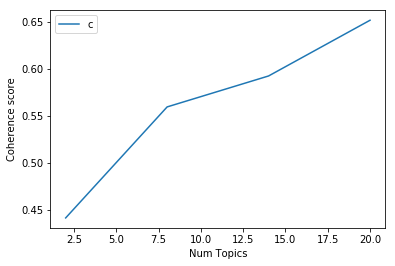

In [163]:
''' Plot the coherence as a function of number of topics '''
limit=25; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [177]:
''' Find the best model by looking at the coherence & the optimal number of topics '''
for i, j in zip(x, coherence_values):
    print("Num Topic:", i,  " has coherence: ", round(j, 2))

best_model = model_list[3]

Num Topic: 2  has coherence:  0.44
Num Topic: 8  has coherence:  0.56
Num Topic: 14  has coherence:  0.59
Num Topic: 20  has coherence:  0.65


In [202]:
''' Find the optimal topic for each document(text or sentence) in each row by selectig the topic with the highest % for each document '''

def topic_per_row(ldamodel=ldamodel, corpus=corpus, texts=news_list):
    
    # Initilize the df where we store the final output
    sent_topics_df = pd.DataFrame()

    # Get the most important topic in each document: for each row, each topic is represented by the % of that topic. sort the % in descending order
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic, there is just one topic
                wp = ldamodel.show_topic(topic_num) # take the topic number
                topic_keywords = ", ".join([word for word, prop in wp]) # join the words together in one list
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,2), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add the content col from the original df to the output
    contents = pd.Series(news_list)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1) 
    return(sent_topics_df)


# Call the function
df_topic_sents_keywords = topic_per_row(ldamodel=best_model, corpus=corpus, texts=news_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [200]:
df_dominant_topic.head(3)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,18.0,0.1924,"car, bike, article, buy, write, road, engine, ...",From: (wheres my thing) Subject: WHAT car is t...
1,1,0.0,0.1879,"drive, card, system, problem, scsi, driver, ma...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,18.0,0.3360,"car, bike, article, buy, write, road, engine, ...",From: (Irwin Arnstein) Subject: Re: Recommenda...


In [204]:
d = df_dominant_topic.sort_values(by=['Topic_Perc_Contrib'], ascending=False)
d.head(3)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
9832,9832,14.0,1.00,"ax, max, tm, qax, mf, giz, _, gq, mr, wm_wm",Subject: roman.bmp 13/14 From: (Cliff) Reply-T...
5507,5507,14.0,1.00,"ax, max, tm, qax, mf, giz, _, gq, mr, wm_wm",Subject: roman.bmp 12/14 From: (Cliff) Reply-T...
10294,10294,14.0,0.99,"ax, max, tm, qax, mf, giz, _, gq, mr, wm_wm",Subject: roman.bmp 11/14 From: (Cliff) Reply-T...


In [214]:
''' Contribution or % of each topic_num in the whole documents or df - distribution of topics across documents'''
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 6)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# display the results
df_dominant_topics.head(3)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,18.0,"car, bike, article, buy, write, road, engine, ...",1284.0,0.113488
1,0.0,"drive, card, system, problem, scsi, driver, ma...",533.0,0.047110
2,18.0,"car, bike, article, buy, write, road, engine, ...",520.0,0.045961
